# Reader+batching+coordinator = Reading data but MNIST fail!!

In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 먼저 가장 간단하게 MNIST를 불러와보자

from tensorflow.examples.tutorials.mnist import input_data
datapath="./MNIST"
data=input_data.read_data_sets(datapath,one_hot=False)

Extracting ./MNIST\train-images-idx3-ubyte.gz
Extracting ./MNIST\train-labels-idx1-ubyte.gz
Extracting ./MNIST\t10k-images-idx3-ubyte.gz
Extracting ./MNIST\t10k-labels-idx1-ubyte.gz


In [3]:
#불러온 김에 간단한 정보를 알아보자.
print(dir(data))
print(type(data.train))   #이 두개는 뭔지 모르는 타입이다, 그냥 두자 
print(type(data.train.images))  #numpy array이다.
print((data.validation.images).shape)
print((data.test.images).shape)
print(data.train.labels.shape)  #numpy에서 shape은 괄호 안친다. label은 불러올 때 one_hot 여부를 결정 할 수 있다.

['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_fields', '_make', '_replace', '_source', 'count', 'index', 'test', 'train', 'validation']
<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>
<class 'numpy.ndarray'>
(5000, 784)
(10000, 784)
(55000,)


In [12]:
"""
이제 queue를 이용하여 데이터를 불러올 것이다.
1.어떤 파일에서 데이터를 불러올 것인지를 명시한다, MNIST는 이미지파일,라벨파일이 나누어져있다. 그래서 두개를 써준다.
2.어떤 리더기로 데이터를 읽어올 것인지를 명시한다, MNIST,CIFAR 같은 데이터셋은 보통 바이너리화 된 데이터파일이다, 그래서 FixedLengthRecordReader를 써준다.
tip:http://yann.lecun.com/exdb/mnist/ 여기에 가면 이 데이터파일에 대한 구성정보가 나와있다, 예를 들어 이미지파일은 헤더가 16바이트 있다고한다.
->header_bytes=16
3.리더기와 파일목록을 연결시켜준다. (key,value)를 리턴하는데 key는 이 설정대로 읽었을 때 몇번째 데이터인지를 나타낸다, value는 데이터의 구체적인 정보
4.binary데이터를 읽은 것이기에 이걸 디코드해주어야한다, 8비트씩 묶어주면 된다.
"""
def __read_cifar(filenames, shuffle=False, cifar100=False):
  """Reads and parses examples from MNIST data files."""
  filename_queue_image = tf.train.string_input_producer(filenames[0], shuffle=shuffle,num_epochs=None)
  filename_queue_label = tf.train.string_input_producer(filenames[1], shuffle=shuffle,num_epochs=None)
  label_bytes = 1
  height = 28
  width = 28
  depth = 1
  image_bytes = height * width * depth
  reader_image = tf.FixedLengthRecordReader(record_bytes=image_bytes,header_bytes=16)
  reader_label = tf.FixedLengthRecordReader(record_bytes=label_bytes,header_bytes=8)
  key_image, value_image = reader_image.read(filename_queue_image)
  key_label, value_label = reader_label.read(filename_queue_label)

  # Convert from a string to a vector of uint8 that is record_bytes long.
  record_bytes_image= tf.decode_raw(value_image, tf.uint8)
  record_bytes_label = tf.decode_raw(value_label, tf.uint8)

  # The first bytes represent the label, which we convert from uint8->int32.
  # The remaining bytes after the label represent the image, which we reshape
  # from [depth * height * width] to [depth, height, width].
    
    
  depth_major = tf.reshape(tf.slice(record_bytes_image, [0], [image_bytes]),  #def slice(input_, begin, size, name=None):
                           [depth, height, width])
  label = tf.cast(tf.slice(record_bytes_label, [0], [label_bytes]), tf.int32)

  image = tf.transpose(depth_major, [1, 2, 0])

  return tf.cast(image, tf.float32),label,key_image,key_label

In [13]:
"""
5.여기서는 batching을 해준다, 이걸 안해주더라도 데이터를 읽을 수는 있다.
"""
class DataProvider:
    def __init__(self, data, size=None, training=True):
        self.size = size or [None]*4
        self.data = data
        self.training = training

    def next_batch(self, batch_size, min_queue_examples=1000, num_threads=8):
        """Construct a queued batch of images and labels.

        Args:
        image: 3-D Tensor of [height, width, 3] of type.float32.
        label: 1-D Tensor of type.int32
        min_queue_examples: int32, minimum number of samples to retain
        in the queue that provides of batches of examples.
        batch_size: Number of images per batch.

        Returns:
        images: Images. 4D tensor of [batch_size, height, width, 3] size.
        labels: Labels. 1D tensor of [batch_size] size.
        """
        # Create a queue that shuffles the examples, and then
        # read 'batch_size' images + labels from the example queue.

        image, label,key_image,key_label = self.data
        if self.training:
            images, label_batch,key_images,key_labels = tf.train.shuffle_batch(
            [image, label,key_image,key_label],
            batch_size=batch_size,
            num_threads=24,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
        else:
            images, label_batch = tf.train.batch(
            [preprocess_evaluation(image, height=self.size[1], width=self.size[2]), label],
            batch_size=batch_size,
            num_threads=num_threads,
            capacity=min_queue_examples + 3 * batch_size)

        return images, tf.reshape(label_batch, [batch_size]),key_images,key_labels
a=DataProvider(__read_cifar([[datapath+'/train-images.idx3-ubyte'],[datapath+'/train-labels.idx1-ubyte']]), [55000, 28,28,1], True)
import os
print(datapath+'/train-images.idx3-ubyte')
print(os.path.isdir(datapath))
print(os.path.isfile(datapath+'/train-images.idx3-ubyte'))  #폴더나 파일 있는지 확인시켜주는 함수
print(os.path.isfile(datapath+'/train-images.idx3-ubyte222'))

./MNIST/train-images.idx3-ubyte
True
True
False


In [14]:
batch_size=64
images,labels,key_images,key_labels=a.next_batch(batch_size)
print("%11s"%"images:",images,"\n%11s"%"labels:",labels,"\n%11s"%"key_images:",key_images,"\n%11s"%"key_labels:",key_labels)

    images: Tensor("shuffle_batch:0", shape=(64, 28, 28, 1), dtype=float32) 
    labels: Tensor("Reshape_7:0", shape=(64,), dtype=int32) 
key_images: Tensor("shuffle_batch:2", shape=(64,), dtype=string) 
key_labels: Tensor("shuffle_batch:3", shape=(64,), dtype=string)


In [15]:
"""
Coordinator가 꼭 필요하다, 위에서 나온건 겉으로 보기에는 멀쩡해보이지만 조정담당이 없으면 데이터를 한개도!! 뱉어내지 못한다.
"""
sess=tf.InteractiveSession()
#sess.run(images)  #여기서 이 코드를 치면 그냥 반응이 없음
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess,coord=coord)

Error: 106 107
Error: 972 971
Error: 554 555
Error: 1136 1135
Error: 466 465
Error: 1397 1396
Error: 742 741
Error: 1052 1050
Error: 978 977
Error: 1299 1298
Error: 663 664
Error: 668 662
Error: 227 226
Error: 1027 1026
Error: 968 967
Error: 456 455
Error: 970 969
Correct list [0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1] 
Error_rate= 0.734375


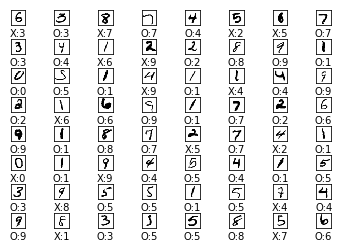

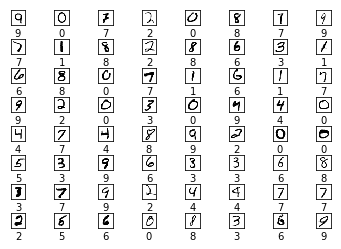

In [22]:
new_img,new_label,new_key_img,new_key_label=sess.run([tf.reshape(images,shape=[64,28,28]),labels,key_images,key_labels])
conv_img,conv_label=data.train.next_batch(64)
fig, axes = plt.subplots(8, 8)
fig.subplots_adjust(hspace=1, wspace=0.5)
correct=[]
for i, ax in enumerate(axes.flat):
    ax.imshow(new_img[i], cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    
    keyofimg=int(str(new_key_img[i]).split(':')[1][:-1])
    keyoflabel=int(str(new_key_label[i]).split(':')[1][:-1])
    if int(str(new_key_img[i]).split(':')[1][:-1])==int(str(new_key_label[i]).split(':')[1][:-1]):
        ax.set_xlabel("O:"+str(new_label[i]))
        correct.append(1)
    else:
        ax.set_xlabel("X:"+str(new_label[i]))
        print("Error:",keyofimg,keyoflabel)
        correct.append(0)
print("Correct list",correct,"\nError_rate=",sum(correct)/batch_size)

fig2, axes2 = plt.subplots(8, 8)
fig2.subplots_adjust(hspace=1, wspace=0.5)
for i, ax in enumerate(axes2.flat):
    ax.imshow(conv_img[i].reshape([28,28]), cmap='binary')
    ax.set_xlabel(str(conv_label[i]))
    ax.set_xticks([])
    ax.set_yticks([])

In [32]:
#전체에서 잘못 매칭된게 몇프로정도 될까?
rate=[]
for i in range(1000):
    error=0
    correct=0
    keyd,keye=sess.run([key_images,key_labels])
    for j in range(batch_size):
        if int(str(keyd[j]).split(':')[1][:-1])==int(str(keye[j]).split(':')[1][:-1]):
            correct+=1
        else:
            error+=1
    rate.append(error/batch_size)
print("약 {0}% 가 잘못 매칭되었다".format(np.mean(rate)))
#위에서 출력 된 결과를 보면 약 84프로만 정확한 라벨링이 된 것을 알 수가 있다. 이런 데이터로 학습을 시키고 있었던 것이다.
#약 84%가 정확하고 16%가 라벨링이 잘못된 것이다. 그래도 맞는게 과반수니까 학습이 되긴 됬겠지, 근데 학습을 잘하면 할 수록 
#남은 16%에서 나오는 loss가 커졌을 것이다, 가면 갈수록 그 loss가 커졌겠지. 그러면 차라리 맞은걸 좀 틀리게하는게 loss를 작게하는 길이 된다.
#그래서 기껏 맞은 것도 틀리게 만드는 것이다.
#85%를 맞추면 15%에서 큰 에러가 발생한다, 85%를 틀리게한다, 그렇다고 15%를 맞춰도 당연히 85%에서 에러가 발생한다.
#상책은 아무것도 맞추지 않는 것, dead relu를 통해 아예 최대한 안맞추는 것이 아닐까! 
#실제 데이터 with new input pipelines:

약 0.158265625% 가 잘못 매칭되었다


In [2]:
coord.request_stop()
coord.join(threads)
coord.clear_stop()
sess.close()


# 2)coordinator없이 데이터 읽으려고 함
# 3)헤더 지정 안해줌
# 4)label하고 이미지하고 다른현상,sess.run
# 5)subplot
# 6)gz file자동압축해제 안되는 현상


NameError: name 'coord' is not defined

#실제 데이터 with conventional input pipelines:

1)1~30에폭까지 꾸준히 정상적인 loss가 나온다, 즉 맞으면 loss가 0이고 틀린부분은 50이하의 loss를 가진다.

2)신기한건 loss가 꽤 크게 있거나 없거나 둘 중하나라는 것이다. 애매하게 있는건 별로 없는거 같았다. 0.02 이런 크기말이야,

3)어느정도 학습되면 loss=0 즉 softmax=1로 정답을 맞추는 경우가 가장 많았다.

#test loss가 작게는 12부터 크게는 400도 넘게 나온다.

1)일단 초반은 잘학습 된다, 다만 매우 극단적인 loss를 보인다, 대다수는 loss=0으로 conv pipeline처럼 나왔지만, 일부가 loss 4000,5000을
넘는 등 극단적인 크기의 loss를 보여주었다.

14에폭:
Output: [[ -5096.1025   -5744.724     7586.3174    5826.7725   -4351.028
   -8080.894    -3714.2378    4734.493     -537.6919   -6580.5835 ]
 [-14106.072   -14143.351   -18813.762    -1420.9341   11941.53
   -5590.0146   -7440.722    15886.897   -18568.383    27102.277  ]
 [ 10920.528    -3112.42       566.8374    7316.6685   -1912.8662
    8392.936      505.01978   5356.3706    1837.103      660.8197 ]
 [ -7862.808    -5394.        3143.6685   30475.129    -3225.7793
    7437.005   -18960.639      722.5259   17315.475    -5762.6914 ]
 [ -2888.802    -5526.786    -7744.4805  -11607.167    31972.475
    1648.7358  -11014.301    19047.256     7396.0503    6609.621  ]
 [ -4529.219    -9401.391    -8650.812     4659.206    18029.865
    7383.712   -14243.9795     491.3877    4501.571    15306.998  ]
 [ -6728.5015   -6977.589     4933.7715   26735.488   -16557.053
   -2271.8813   -6192.5996   -5935.004     1526.9971   -8423.485  ]
 [ -6725.7744   -9651.228      815.70654  18210.922    -5113.885
   -7433.1777  -34496.855    35855.3     -23456.459     9888.04   ]
 [   719.3242   -8234.347     9645.719     3735.9949   -2487.1995
   -5237.789     -559.7739   36230.453    -8516.099    13445.983  ]
 [ -2711.7559  -14637.682    -3163.8975   30944.379    -5866.853
   16403.207   -15421.557      940.8179   -1493.5579   -1841.1096 ]]

Softmax: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
loss: [1759.5449    0.        0.        0.        0.     2722.8672    0.
    0.        0.        0.    ]
    
2)중반: 슬슬 학습을 포기하고 회의주의로 돌아선다. 아예 0으로 보내버리는 dead relu폭격

60에폭:정확도 46퍼센트, 평균 loss 2.925

Output: [[     0.            0.            0.            0.            0.
       0.            0.            0.            0.            0.      ]     
 [0.            0.            0.            0.            0.
       0.            0.            0.            0.            0.      ]      
 [ -2395.8232    -1450.8643     1998.9674     -824.58765    1820.2753
    1997.2166     2713.2026    -2337.6987     1755.4341     2098.2712  ]   
 [     0.            0.            0.            0.            0.
       0.            0.            0.            0.            0.      ]      
 [ -8280.872     -5055.1123   -10151.541      1643.0497    -3329.3105
   -7540.1074   -11126.327     11664.315    -10692.928     -4545.6636  ]  
 [ -4348.2446    -2919.8843     2145.1743    -2556.33       2224.9924
   -3539.7812    -3527.099      3745.1885    -3211.284      1438.8232  ]  
 [     0.            0.            0.            0.            0.
       0.            0.            0.            0.            0.      ]     
 [   -66.33222     -57.503887    -63.434444     68.02157     -35.916443
      73.43204     -70.31772      83.190506    -72.057594    -68.08871 ]     
 [ -6164.706      8349.892     -6636.175     -6682.9795    -1675.9426
   -1630.8364    -2346.4707     4141.618     -6232.8945    -1872.0594  ]  
 [     0.            0.            0.            0.            0.
       0.            0.            0.            0.            0.      ]]

Softmax: [[1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5833833e-07 0.0000000e+00
  5.7799720e-05 0.0000000e+00 9.9994195e-01 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]]

loss: [2.3025851e+00 2.3025851e+00 0.0000000e+00 2.3025851e+00 0.0000000e+00
 0.0000000e+00 2.3025851e+00 5.8053240e-05 0.0000000e+00 2.3025851e+00]

3)학습후반: 80에폭쯤 되면 40%정확도에서 더 내려가지 않고 saturation 된다. 이 때의 평균 loss는 training set에서 2 좌우정도로 꽤나 낮다.
생각해보면 극단적인 loss를 내는 녀석들을 포기하기 위해 포기해야 되는 정답을 다 포기하고, 남은 녀석들이 40프로정도 되는거 아닐까?(포기한다는건 결국 등가판단을 하겠다는것)

Output: [[-10095.848    -7854.411    -5546.6255   -3975.8188   -3661.5898
   -4223.8086  -11640.502    12372.021   -10089.551    -4811.543  ]
 [     0.           0.           0.           0.           0.
       0.           0.           0.           0.           0.     ]
 [     0.           0.           0.           0.           0.
       0.           0.           0.           0.           0.     ]
 [   286.73782    357.61267   -298.43484    252.19225   -253.84402
     405.57953    336.43307    307.90277   -378.90268   -322.6846 ]
 [     0.           0.           0.           0.           0.
       0.           0.           0.           0.           0.     ]
 [     0.           0.           0.           0.           0.
       0.           0.           0.           0.           0.     ]
 [     0.           0.           0.           0.           0.
       0.           0.           0.           0.           0.     ]
 [ -3349.9885   -2348.0898    2577.8845   -2800.8508    2592.9478
   -2615.352    -2566.6406    2836.4788   -2189.6182    1965.0226 ]
 [ -1447.0885    -716.2301    -993.1721     779.61426   1069.944
    -906.1983   -1165.6647   -1267.0381   -1436.3494   -1280.3374 ]
 [     0.           0.           0.           0.           0.
       0.           0.           0.           0.           0.     ]]
Softmax: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [0.0000000e+00 1.4731884e-21 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 9.3341906e-31 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01
  1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01 1.0000000e-01]]
loss: [0.        2.3025851 2.3025851 0.        2.3025851 2.3025851 2.3025851
 0.        0.        2.3025851]

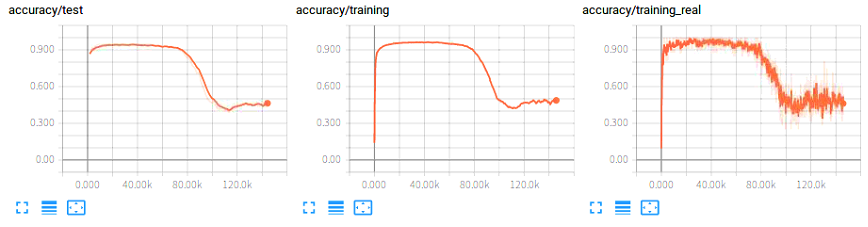

In [3]:
from IPython.display import Image
Image("./20180330shot01.png")